In [54]:
%matplotlib widget
import os
import h5py
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time
from IPython.display import Image, display
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks
# import hdbscan
plt.rcParams.update({'font.size': 12})

In [2]:
def convert_time_to_string(dt):
    epoch = dt + datetime.datetime.timestamp(datetime.datetime(2018,1,1))
    return datetime.datetime.fromtimestamp(epoch).strftime("%Y-%m-%d, %H:%M:%S")

def read_melt_lake_h5(fn):
    
    lakedict = {}
    with h5py.File(fn, 'r') as f:

        # metadata
        for key in f['properties'].keys(): 
            lakedict[key] = f['properties'][key][()]
            if f['properties'][key].dtype == object:
                lakedict[key] = lakedict[key].decode('utf-8')
                

        # photon data
        photon_data_dict = {}
        for key in f['photon_data'].keys():
            photon_data_dict[key] = f['photon_data'][key][()]
        lakedict['photon_data'] = pd.DataFrame(photon_data_dict)

        # mframe data
        mframe_data_dict = {}
        for key in f['mframe_data'].keys():
            mframe_data_dict[key] = f['mframe_data'][key][()]
        lakedict['mframe_data'] = pd.DataFrame(mframe_data_dict).set_index('mframe')    

        # second returns data
        det_2nds_dict = {}
        for key in f['detection_2nd_returns'].keys():
            det_2nds_dict[key] = f['detection_2nd_returns'][key][()]
        lakedict['detection_2nd_returns'] = det_2nds_dict

        # quality assessment data
        qual_dict = {}
        for key in f['detection_quality_info'].keys():
            qual_dict[key] = f['detection_quality_info'][key][()]
        lakedict['detection_quality_info'] = qual_dict
        
        # re-nest the lake extent segments
        def re_nest_extent(x): return [[x[i], x[i+1]] for i in np.arange(0,len(x),2)]
        lakedict['surface_extent_detection'] = re_nest_extent(lakedict['surface_extent_detection'])
        lakedict['lat_surface_extent_detection'] = re_nest_extent(lakedict['lat_surface_extent_detection'])
        
        lakedict['date_time'] = convert_time_to_string(lakedict['mframe_data']['dt'].mean())
        
        return lakedict

class dictobj:
    def __init__(self, in_dict:dict):
        assert isinstance(in_dict, dict)
        for key, val in in_dict.items():
            setattr(self, key, val)
    #-------------------------------------------------------------------------------------
    def plot_detected(self, fig_dir='figs', verbose=False, min_width=0.0, min_depth=0.0, print_mframe_info=True):

        if len(self.detection_2nd_returns['h'])>0:
            lake_minh = np.min(self.detection_2nd_returns['h'])
        else: return
        lake_max_depth = np.abs(self.main_peak - np.min(self.detection_2nd_returns['h']))
        lake_segment_length = np.abs(np.max(self.detection_2nd_returns['xatc']) - np.min(self.detection_2nd_returns['xatc']))
        lake_maxh = np.min((self.mframe_data['peak'].max(), self.main_peak+0.5*lake_max_depth))
        buffer_bottom = np.max((0.5*lake_max_depth, 2.0))
        lake_minh_plot = lake_minh - buffer_bottom
        buffer_top = (lake_maxh - lake_minh_plot) * 0.5
        lake_maxh_plot = lake_maxh + buffer_top
        ylms = (lake_minh_plot, lake_maxh_plot)
        xlms = (0.0, self.mframe_data.xatc_max.max())

        if (lake_max_depth > min_depth) & (lake_segment_length > min_width):
            fig, ax = plt.subplots(figsize=[9, 5], dpi=100)

            # plot the ATL03 photon data
            scatt = ax.scatter(self.photon_data.xatc, self.photon_data.h,s=5, c=self.photon_data.snr, alpha=1, 
                               edgecolors='none', cmap=cmc.lajolla, vmin=0, vmax=1)
            p_scatt = ax.scatter([-9999]*4, [-9999]*4, s=15, c=[0.0,0.25,0.75,1.0], alpha=1, edgecolors='none', cmap=cmc.lajolla, 
                                 vmin=0, vmax=1, label='ATL03 photons')

            # plot surface elevation
            for xtent in self.surface_extent_detection:
                ax.plot(xtent, [self.surface_elevation, self.surface_elevation], 'g-', lw=3)
            p_surf_elev, = ax.plot([-9999]*2, [-9999]*2, 'g-', lw=3, label='lake surface')

            # plot the second returns from detection
            for j, prom in enumerate(self.detection_2nd_returns['prom']):
                ax.plot(self.detection_2nd_returns['xatc'][j], self.detection_2nd_returns['h'][j], 
                                        marker='o', mfc='none', mec='b', linestyle = 'None', ms=prom*8)
            p_2nd_return, = ax.plot(-9999, -9999, marker='o', mfc='none', mec='b', ls='None', ms=3, label='second returns')

            # plot mframe bounds
            ymin, ymax = ax.get_ylim()
            mframe_bounds_xatc = list(self.mframe_data['xatc_min']) + [self.mframe_data['xatc_max'].iloc[-1]]
            for xmframe in mframe_bounds_xatc:
                ax.plot([xmframe, xmframe], [ymin, ymax], 'k-', lw=0.5)

            # visualize which segments initially passed
            for i, passing in enumerate(self.mframe_data['lake_qual_pass']):
                mf = self.mframe_data.iloc[i]
                if passing:
                    xy = (mf.xatc_min, ylms[0])
                    width = mf.xatc_max - mf.xatc_min
                    height = ylms[1] - ylms[0]
                    rct = Rectangle(xy, width, height, ec=(1,1,1,0), fc=(0,0,1,0.1), zorder=-1000, label='major frame passed lake check')
                    p_passed = ax.add_patch(rct)
                p_mfpeak, = ax.plot((mf.xatc_min,mf.xatc_max), (mf.peak,mf.peak),'k-',lw=0.5, label='major frame peak')

            # add a legend
            hdls = [p_scatt, p_surf_elev, p_2nd_return, p_mfpeak, p_passed]
            ax.legend(handles=hdls, loc='lower left', fontsize=7, scatterpoints=4)

            # add the colorbar 
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='4%', pad=0.05)
            cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
            cbar.ax.get_yaxis().set_ticks([])
            for j, lab in enumerate([0.2, 0.4, 0.6, 0.8]):
                cbar.ax.text(.5, lab, '%.1f'%lab, ha='center', va='center', fontweight='black')
            cbar.ax.get_yaxis().labelpad = 15
            cbar.ax.set_ylabel('photon density', rotation=270, fontsize=8)

            # add labels and description in title
            txt  = 'ICESat-2 Lake Detection: %s, ' % ('Greenland Ice Sheet' if self.lat>=0 else 'Antarctic Ice Sheet')
            txt += '%s Melt Season' % self.melt_season
            fig.suptitle(txt, y=0.95, fontsize=14)

            txt  = 'location: %s, %s (area: %s) | ' % (self.lat_str, self.lon_str, self.polygon_name)
            txt += 'time: %s UTC | surface elevation: %.2f m\n' % (self.date_time, self.surface_elevation)
            txt += 'RGT %s %s cycle %i | ' % (self.rgt, self.gtx.upper(), self.cycle_number)
            txt += 'beam %i (%s, %s spacecraft orientation) | ' % (self.beam_number, self.beam_strength, self.sc_orient)
            txt += 'granule ID: %s' % self.granule_id
            ax.set_title(txt, fontsize=8)

            ax.set_ylabel('elevation above geoid [m]',fontsize=8)
            ax.tick_params(axis='x', which='major', labelsize=7)
            ax.tick_params(axis='y', which='major', labelsize=6)
            # set limits
            ax.set_ylim(ylms)
            ax.set_xlim(xlms)

            # add latitude
            #_________________________________________________________
            lx = self.photon_data.sort_values(by='lat').iloc[[0,-1]][['lat','xatc']].reset_index(drop=True)
            lat = np.array(lx.lat)
            xatc = np.array(lx.xatc)
            def forward(x):
                return lat[0] + x * (lat[1] - lat[0]) / (xatc[1] - xatc[0])
            def inverse(l):
                return xatc[0] + l * (xatc[1] - xatc[0]) / (lat[1] - lat[0])
            secax = ax.secondary_xaxis(-0.065, functions=(forward, inverse))
            secax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
            secax.set_xlabel('latitude / along-track distance',fontsize=8,labelpad=0)
            secax.tick_params(axis='both', which='major', labelsize=7)
            secax.ticklabel_format(useOffset=False) # show actual readable latitude values

            # rename x ticks
            xticklabs = ['%g km' % (xt/1000) for xt in list(ax.get_xticks())]
            ticks = ax.get_xticks()
            ax.set_xticks(ticks)
            ax.set_xticklabels(xticklabs)

            # add mframe info text
            if print_mframe_info:
                txt  = 'mframe:\n' % (mf.name%1000)
                txt += 'photons:\n' % mf.n_phot
                txt += 'peak:\n'
                txt += 'flat:\n'
                txt += 'SNR surf all:\n'
                txt += 'SNR surf above:\n'
                txt += 'SNR up:\n'
                txt += 'SNR low:\n'
                txt += '2nds:\n'
                txt += '2nds strength:\n'
                txt += '2nds number:\n'
                txt += '2nds spread:\n'
                txt += '2nds align:\n'
                txt += '2nds quality:\n'
                txt += 'pass:'
                # trans = ax.get_xaxis_transform()
                bbox = {'fc':(1,1,1,0.75), 'ec':(1,1,1,0), 'pad':1}
                ax.text(-0.005, 0.98, txt, transform=ax.transAxes, fontsize=4, ha='right', va='top', bbox=bbox)
                for i,loc in enumerate(self.mframe_data['xatc']):
                    mf = self.mframe_data.iloc[i]
                    txt  = '%i\n' % (mf.name%1000)
                    txt += '%i\n' % mf.n_phot
                    txt += '%.2f\n' % mf.peak
                    txt += '%s\n' % ('Yes.' if mf.is_flat else 'No.')
                    txt += '%i\n' % np.round(mf.snr_surf)
                    txt += '%i\n' % np.round(mf.snr_allabove)
                    txt += '%i\n' % np.round(mf.snr_upper)
                    txt += '%i\n' % np.round(mf.snr_lower)
                    txt += '%i%%\n' % np.round(mf.ratio_2nd_returns*100)
                    txt += '%.2f\n' % mf.quality_secondreturns
                    txt += '%.2f\n' % mf.length_penalty
                    txt += '%.2f\n' % mf.range_penalty
                    txt += '%.2f\n' % mf.alignment_penalty
                    txt += '%.2f\n' % mf.quality_summary
                    txt += '%s' % ('Yes.' if mf.lake_qual_pass else 'No.')
                    trans = ax.get_xaxis_transform()
                    bbox = {'fc':(1,1,1,0.75), 'ec':(1,1,1,0), 'pad':1}
                    ax.text(loc, 0.98, txt, transform=trans, fontsize=4,ha='center', va='top', bbox=bbox)

            # add detection quality description
            txt  = 'LAKE QUALITY: %6.4f'%self.detection_quality
            txt += '\n---------------------------\n'
            txt += '2nd returns: %6.4f\n' % self.detection_quality_info['strength_2nd_returns']
            txt += 'alignment: %6.4f\n' % self.detection_quality_info['qual_alignment']
            txt += 'depth: %6.4f\n' % self.detection_quality_info['lake_depth']
            txt += 'length: %6.4f\n' % self.detection_quality_info['lake_length']
            txt += 'depth range: %6.4f' % self.detection_quality_info['h_range_2nd_returns']
            bbox = {'fc':(1,1,1,0.75), 'ec':(1,1,1,0), 'pad':1}
            ax.text(0.99, 0.02, txt, transform=ax.transAxes, ha='right', va='bottom',fontsize=6, weight='bold', bbox=bbox)

            fig.patch.set_facecolor('white')
            fig.tight_layout()
            ax.set_ylim(ylms)
            ax.set_xlim(xlms)

            # plt.close(fig)

            return fig

In [3]:
searchfor = 'lake_'
searchdir = 'WAIS_region_comps/'
filelist = [searchdir+f for f in os.listdir(searchdir) \
            if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f) & ('.h5' in f)]

In [35]:
refractive_index = 1.333
df_list = []
for i, fn in enumerate(filelist):
    'west_greenland'
    'amery'
    'george_vi'
    lk = read_melt_lake_h5(fn)
    df = pd.DataFrame(lk['detection_2nd_returns'])
    df['depth'] = lk['surface_elevation'] - df.h
    if 'west_greenland' in fn:
        region = 'west_greenland'
    elif 'amery' in fn:
        region = 'amery'
    elif 'george_vi' in fn:
        region = 'george_vi'
    else: 
        region = 'other'
    df['region'] = region
    df['lake_qual'] = lk['detection_quality']
    df['id'] = i
    
    df_list.append(df)
    print('%i / %i' % (i+1, len(filelist)), end='\r')

df_all = pd.concat(df_list)

In [36]:
# pklfn = 'depth_detection_regions_df.pkl'
# df_all.to_pickle(pklfn)
# df_all = pd.read_pickle(pklfn)

In [38]:
df_all.groupby('id')['depth'].median()

id
0       4.129867
1       1.940208
2       3.999781
3       5.775491
4       3.206852
          ...   
1954    2.377694
1955    1.157500
1956    2.544383
1957    2.822720
1958    2.347032
Name: depth, Length: 1938, dtype: float64

In [48]:
dh = 0.1
smoothing = 1.0
bins = np.arange(0, 15+dh, dh)
mids = bins[:-1] + np.diff(bins)

keys = ['george_vi', 'amery', 'west_greenland']
hist_dict = {}
hist_smooth_dict = {}
for k in keys:
    df_region = df_all[df_all.region==k].copy()
    # lakedepths = df_region.groupby('id')[['depth', 'lake_qual']].mean()
    # hist = np.histogram(lakedepths.depth, bins=bins, weights=lakedepths.lake_qual)[0]
    hist = np.histogram(df_region.depth, bins=bins, weights=df_region.prom)[0]
    wdw = int(np.ceil(smoothing / dh))
    hist_smooth = pd.Series(hist).rolling(window=wdw, min_periods=1, center=True).mean()
    hist_smooth /= np.sum(hist_smooth)
    hist_smooth_dict[k] = hist_smooth

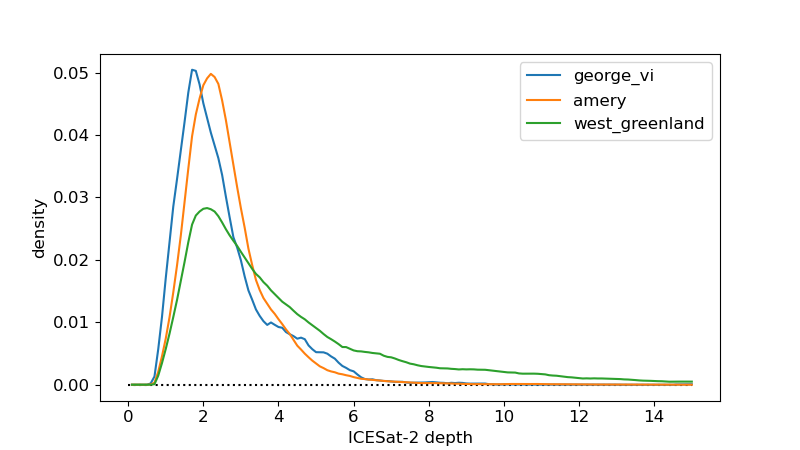

In [56]:
fig, ax = plt.subplots(figsize=[8, 4.5], dpi=100)
ax.plot([0,15], [0,0], 'k:')
for k in keys:
    ax.plot(mids, hist_smooth_dict[k], label=k)
ax.set_xlabel('ICESat-2 depth')
ax.set_ylabel('density')
ax.legend(loc='upper right')